In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from subprocess import STDOUT
from pathlib import Path
import logging
import pickle
import sys
logging.getLogger().setLevel(logging.INFO)
DATA_DIR = os.environ.get("DATA_DIR") or "/home/bookboi/Nextcloud/1_Docs/4_Master/20_Studienarbeit_paper/data/datensatz_dominik/2 (copy)/"
plt.style.use("matplotlib.rc")
from calibration_tool.data_integration.data_set import DataSet
from calibration_tool.sumo.sumo_interface import SumoInterface
from calibration_tool.sumo.sumo_project import SumoProject
from calibration_tool.fileaccess.parameter import EidmParameters
from calibration_tool.optimization.optimization import (
    objective_function, TargetCollector) 
dataset = DataSet(DATA_DIR)
os.environ["SUMO_HOME"] = "/usr/share/sumo" if sys.platform == "linux" else "C:\\Studienarbeit_Calibration\\sumo-1.15.0"

In [2]:
outputpath = Path(".tmp")
results_data = pd.read_csv(outputpath / "calibration_results_genetic_algorithm.csv", index_col=0)
results_data.head()

,iteration,weightedError,speedFactor,minGap,accel,decel,emergencyDecel,startupDelay,tau,delta,...,sigmagap,sigmaerror,jerkmax,epsilonacc,taccmax,Mflatness,Mbegin,leader,follower,recordingId
0,1,0.186112,1.2,1.184918,0.266187,0.262399,10,0.769246,0.053066,4.178826,...,0,0,2.772819,2.032566,3.597744,2.961903,1.155682,88.0,95.0,1.0
1,2,0.186112,1.2,1.184918,0.266187,0.262399,10,0.769246,0.053066,4.178826,...,0,0,2.772819,2.032566,3.597744,2.961903,1.155682,88.0,95.0,1.0
2,3,0.143390,1.2,4.000000,2.524136,0.100000,10,0.447228,0.162803,4.483776,...,0,0,2.772819,2.032566,3.597744,2.961903,1.155682,88.0,95.0,1.0
3,4,0.142656,1.2,4.000000,2.524136,0.100000,10,0.447228,0.040000,4.483776,...,0,0,2.772819,2.032566,3.597744,2.961903,1.155682,88.0,95.0,1.0
4,5,0.140766,1.2,4.000000,2.524136,0.100000,10,0.447228,0.162803,4.483776,...,0,0,2.772819,2.032566,3.597744,1.000000,1.155682,88.0,95.0,1.0


In [3]:
def get_param_set(results_chunk: pd.DataFrame, iteration: int) -> dict:
    param_set = results_chunk[results_chunk["iteration"]==iteration].iloc[0].to_dict()
    keys = list(EidmParameters.get_defaults_dict().keys())
    return {key: param_set[key] for key in keys}

def get_unique_calibrations(results: pd.DataFrame):
    calibration = (results
                   .groupby(["leader", "follower", "recordingId"], as_index=False))
    ids, ind = np.unique(results[["leader", "follower", "recordingId"]].values, axis=0, return_index=True)
    ids = ids[np.argsort(ind)]
    for id in ids:
        yield tuple(id), calibration.get_group(tuple(id))
    
def simulate_single(identification, results_chunk, sumo_interface):
    param_sets = {}
    for iteration in results_chunk["iteration"].unique():
        param_sets.update({iteration: get_param_set(results_chunk, iteration)})
    simulation_results = run_sumo(identification, sumo_interface, param_sets)
    return simulation_results

def run_sumo(identification, sumo_interface, param_set):
    eidm0 = EidmParameters.create_eidm_parameter_set(f"set0_0.json", **param_set)
    SumoProject.create_sumo(Path(".tmp/sumo_project_analysis/"), eidm0, 1)
    SumoProject.write_followers_leader(Path(".tmp/sumo_project_analysis/") / "calibration_routes.rou.xml", [eidm0])
    simulation_result = sumo_interface.run_simulation(identification=identification)
    return simulation_result[1]

np.random.seed(2023)
sumo = SumoInterface(Path(".tmp/sumo_project_analysis/"),
                Path(DATA_DIR), gui=False)
simulation_requests = [
    [(88, 95, 1), {'speedFactor': 1.2, 'minGap': 1.1849180547987987, 'accel': 0.2661872328745397, 'decel': 0.2623991845250747, 'emergencyDecel': 10.0, 'startupDelay': 0.7692462795916274, 'tau': 0.053066014729109, 'delta': 4.178825956914515, 'stepping': 0.25, 'tpreview': 4.064297349074459, 'tPersDrive': 1.3787870035003638, 'tPersEstimate': 12.790648145441764, 'treaction': 0.8705747999439517, 'ccoolness': 0.490136359265486, 'sigmaleader': 0.0, 'sigmagap': 0.0, 'sigmaerror': 0.0, 'jerkmax': 2.7728189047127936, 'epsilonacc': 2.032565900381476, 'taccmax': 3.59774416884806, 'Mflatness': 2.961903030707419, 'Mbegin': 1.1556824915652837}],
    [(88, 95, 1), {'speedFactor': 1.2, 'minGap': 1.1849180547987987, 'accel': 0.2661872328745397, 'decel': 0.2623991845250747, 'emergencyDecel': 10.0, 'startupDelay': 0.7692462795916274, 'tau': 0.053066014729109, 'delta': 4.178825956914515, 'stepping': 0.25, 'tpreview': 4.064297349074459, 'tPersDrive': 1.3787870035003638, 'tPersEstimate': 12.790648145441764, 'treaction': 0.8705747999439517, 'ccoolness': 0.490136359265486, 'sigmaleader': 0.0, 'sigmagap': 0.0, 'sigmaerror': 0.0, 'jerkmax': 2.7728189047127936, 'epsilonacc': 2.032565900381476, 'taccmax': 3.59774416884806, 'Mflatness': 2.961903030707419, 'Mbegin': 1.1556824915652837}],
    [(88, 95, 1), {'speedFactor': 1.2, 'minGap': 1.1849180547987987, 'accel': 0.2661872328745397, 'decel': 0.2623991845250747, 'emergencyDecel': 10.0, 'startupDelay': 0.7692462795916274, 'tau': 0.053066014729109, 'delta': 4.178825956914515, 'stepping': 0.25, 'tpreview': 4.064297349074459, 'tPersDrive': 1.3787870035003638, 'tPersEstimate': 12.790648145441764, 'treaction': 0.8705747999439517, 'ccoolness': 0.490136359265486, 'sigmaleader': 0.0, 'sigmagap': 0.0, 'sigmaerror': 0.0, 'jerkmax': 2.7728189047127936, 'epsilonacc': 2.032565900381476, 'taccmax': 3.59774416884806, 'Mflatness': 2.961903030707419, 'Mbegin': 1.1556824915652837}]
    ]
simulation_results = []
for identification, param_set in simulation_requests:
    simulation_result = run_sumo(identification, sumo, param_set)
    simulation_results.append(simulation_result)
del sumo

2023-02-01 09:46:56 INFO     executing:sumo --step-length=0.04 -e 5 --net-file .tmp/sumo_project_analysis/calibration_network.xml --route-files .tmp/sumo_project_analysis/calibration_routes.rou.xml -C .tmp/sumo_project_analysis/calibration_config.sumocfg
2023-02-01 09:46:57 INFO     sumo --step-length=0.04 -e 5 --net-file .tmp/sumo_project_analysis/calibration_network.xml --route-files .tmp/sumo_project_analysis/calibration_routes.rou.xml -C .tmp/sumo_project_analysis/calibration_config.sumocfg 
output:b''
2023-02-01 09:47:06 INFO     Finished 1/1 sumo chunks.
2023-02-01 09:47:06 INFO     executing:sumo --step-length=0.04 -e 5 --net-file .tmp/sumo_project_analysis/calibration_network.xml --route-files .tmp/sumo_project_analysis/calibration_routes.rou.xml -C .tmp/sumo_project_analysis/calibration_config.sumocfg
2023-02-01 09:47:06 INFO     sumo --step-length=0.04 -e 5 --net-file .tmp/sumo_project_analysis/calibration_network.xml --route-files .tmp/sumo_project_analysis/calibration_route

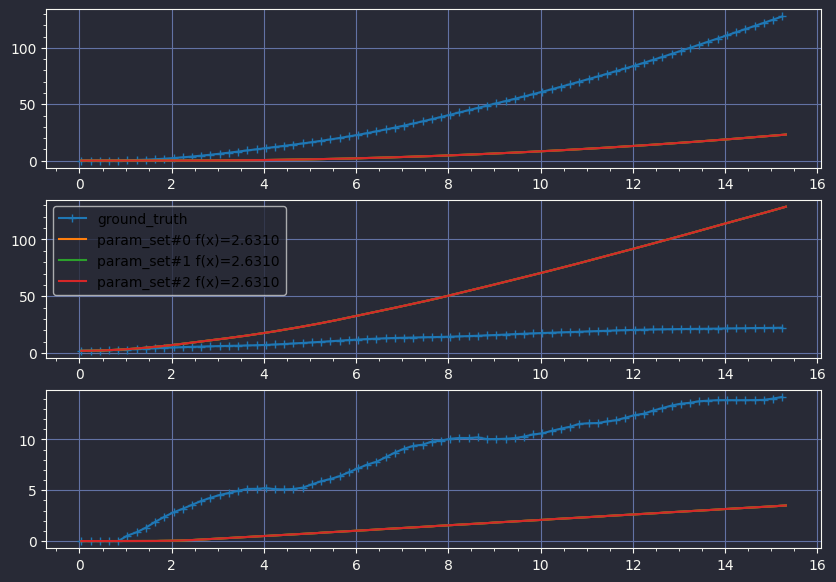

In [4]:
def get_weighted_errors(param_set, simulation_result, indentification):
    weighted_errors = []
    for jdx, _ in param_set.items():
        pred, gt = \
            TargetCollector.get_results({1: simulation_result}, identification, jdx-1)
        weighted_error = objective_function(gt, pred)
        weighted_errors.append(weighted_error)
    return weighted_errors

fig, axes = plt.subplots(3, 1, figsize=(10,7))
jdx = 0
for (identification, param_set), simulation_result in zip(simulation_requests, simulation_results):
    gt = simulation_result["ground_truth"]
    pred = simulation_result["prediction"]
    if jdx == 0:
        x = gt["time"]
        covered_distance = gt["coveredDistanceFollower"]
        axes[0].plot(x[::5], covered_distance[::5], label = "ground_truth", marker="+")
        distance = gt["distance"]
        axes[1].plot(x[::5], distance[::5], label = "ground_truth", marker="+")
        speed = gt["speedFollower"]
        axes[2].plot(x[::5], speed[::5], label = "ground_truth", marker="+")
    weighted_error = objective_function(gt, pred)
    x = pred["time"]
    covered_distance = pred["coveredDistanceFollower"]
    distance = pred["distance"]
    speed = pred["speedFollower"]
    axes[0].plot(x, covered_distance, label = f"param_set#{jdx}")
    axes[1].plot(x, distance, label = f"param_set#{jdx} f(x)={weighted_error:.4f}")
    axes[2].plot(x, speed, label = f"param_set#{jdx}")
    jdx += 1
axes[1].legend()
plt.show()